In [15]:
!nvidia-smi

Mon Mar 18 19:12:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0              N/A / ERR! |    126MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
import torch
import torch.nn as nn

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [17]:
torch.cuda.is_available()

True

In [18]:
torch.get_num_threads()

4

In [19]:
# create if not existts directory for models
!mkdir -p ./lab2-models

model_dir = './lab2-models'

1) Zwiekszenie batch size -> szbyciej sie uczy, ale mniej dokladnie
2) Zwiekszenie batch size oraz learning rate -> szybsza nauka przy takiej samej dokladnosci
3) SGD vs ADAM
4) Learning rate adjactments -> https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
5) Adding Momentum
6) 

In [20]:
# download mnist 
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

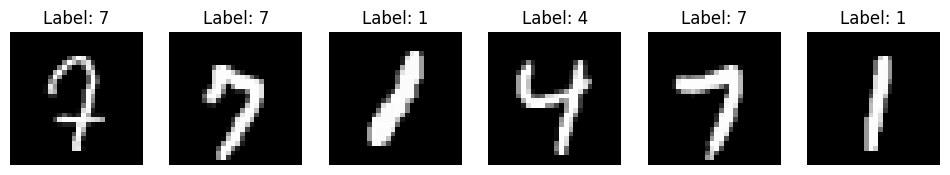

In [21]:
# sample data
import matplotlib.pyplot as plt

import numpy as np

loader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)

dataiter = iter(loader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = labels[i].item()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [22]:
# define model
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)        
        # return F.log_softmax(x, dim=1)
        return x

In [23]:
# train model

import torch.optim as optim
from sklearn.metrics import precision_score, f1_score
import time

def train(net, trainloader, criterion, optimizer):
    learning_start = time.time()
    
    net.train()

    accuracies = []
    losses = []
    f1s = []

    epochs = 10
    points_to_print = 200
    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))

    for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0
    
    learning_end = time.time()

    return losses, accuracies, f1s, learning_end - learning_start    

In [24]:
# test model

from torchmetrics import classification as metrics

def test(net, testloader, criterion, classnum):
    testing_start = time.time()
    
    accuracy = metrics.MulticlassAccuracy(num_classes=classnum, average='macro').cuda()
    f1 = metrics.MulticlassF1Score(num_classes=classnum, average='macro').cuda()
    total_loss = 0.0

    with torch.no_grad():
        net.eval()
        
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            accuracy.update(outputs, labels)
            f1.update(outputs, labels)
            
    
    testing_end = time.time()

    return total_loss / len(testloader), accuracy.compute().item(), f1.compute().item(), testing_end - testing_start

In [25]:
# plot training metrics

def plot(train_losses, train_accuracies, train_f1s):
    fig, ax1 = plt.subplots()
    
    metric_min = min(min(train_accuracies), min(train_f1s))

    color = 'tab:red'
    ax1.set_xlabel('batch')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(train_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([metric_min, 1])

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color = 'tab:gray'
    ax3.set_ylabel('f1', color=color)
    ax3.plot(train_f1s, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim([metric_min, 1])
    
    ax1.set_xlim([0, 200])

    fig.tight_layout()
    plt.title('Train accuracy, loss, precision and f1')
    plt.show()

In [26]:
def show_metrics(model):
    print(f'Name: {model.name}')
    print(f'Train time: {model.train_time:.2f} s')
    print(f'Test time: {model.test_time:.2f} s')
    print(f'Test loss: {model.test_loss:.3f}')
    print(f'Test accuracy: {model.test_accuracy*100:.3f}%')
    print(f'Test f1: {model.test_f1:.3f}')

In [27]:
# model wrapper

import pickle


class Model:
    def __init__(self, name, net, trainloader, criterion, optimizer):
        self.name = name
        self.net = net
        self.trainloader = trainloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.train_accuracies = []
        self.train_f1s = []
        self.train_time = 0

        self.test_loss = 0
        self.test_accuracy = 0
        self.test_f1 = 0
        self.test_time = 0

    def train_and_test(self):
        self.train()
        self.test()

    # train model
    def train(self):
        print(f'Training {self.name}...')
        self.train_losses, self.train_accuracies, self.train_f1s, self.train_time = train(
            self.net, self.trainloader, self.criterion, self.optimizer)

        self.save()

    # test model
    def test(self):
        print(f'Testing {self.name}...')
        self.test_loss, self.test_accuracy, self.test_f1, self.test_time = test(
            self.net, testloader, self.criterion, len(testset.classes))

        return self.test_accuracy, self.test_f1, self.test_time

    # plot model
    def plot(self):
        plot(self.train_losses, self.train_accuracies, self.train_f1s)

    def show_table(self):
        show_metrics(self)

    # save self to file
    def save(self):
        print(f'Saving {self.name}...')
        torch.save(self.net.state_dict(), f'{model_dir}/{self.name}.pth')

        with open(f'{model_dir}/{self.name}.pkl', 'wb') as f:
            pickle.dump(self, f)

    # load self from file
    @classmethod
    def load(cls, name):
        with open(f'{model_dir}/{name}.pkl', 'rb') as f:
            return pickle.load(f)

In [28]:
net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

baseline_model = Model('baseline-model', net, trainloader, criterion, optimizer)
baseline_model.train_and_test()

baseline_model.show_table()

Training baseline-model...
[1,    24] loss: 2.118, accuracy: 0.273
[1,    48] loss: 1.211, accuracy: 0.636
[1,    72] loss: 0.666, accuracy: 0.789
[1,    96] loss: 0.432, accuracy: 0.865
[1,   120] loss: 0.310, accuracy: 0.898
[1,   144] loss: 0.285, accuracy: 0.916
[1,   168] loss: 0.238, accuracy: 0.928
[1,   192] loss: 0.207, accuracy: 0.944
[1,   216] loss: 0.220, accuracy: 0.934
[1,   240] loss: 0.185, accuracy: 0.943
[1,   264] loss: 0.150, accuracy: 0.956
[1,   288] loss: 0.160, accuracy: 0.952
[1,   312] loss: 0.152, accuracy: 0.954
[1,   336] loss: 0.140, accuracy: 0.955
[1,   360] loss: 0.127, accuracy: 0.958
[1,   384] loss: 0.115, accuracy: 0.963
[1,   408] loss: 0.133, accuracy: 0.960
[1,   432] loss: 0.114, accuracy: 0.966
[1,   456] loss: 0.128, accuracy: 0.964
[1,   480] loss: 0.098, accuracy: 0.968
[2,    24] loss: 0.112, accuracy: 0.968
[2,    48] loss: 0.098, accuracy: 0.963
[2,    72] loss: 0.093, accuracy: 0.971
[2,    96] loss: 0.102, accuracy: 0.968
[2,   120] lo

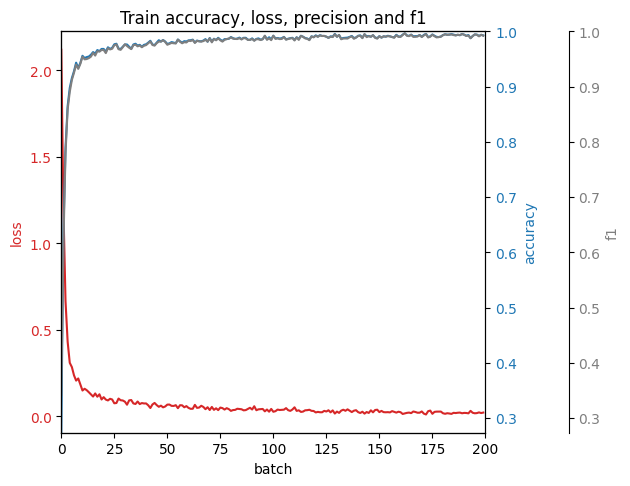

In [29]:
baseline_model.plot()

In [30]:
# Hipothesis 1: increase batch size results in faster learning and worse accuracy

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

batch_size_model = Model('hip-1-model', net, trainloader, criterion, optimizer)
batch_size_model.train_and_test()

batch_size_model.show_table()

Training hip-1-model...
[1,     3] loss: 2.299, accuracy: 0.095
[1,     6] loss: 2.280, accuracy: 0.101
[1,     9] loss: 2.252, accuracy: 0.213
[1,    12] loss: 2.204, accuracy: 0.317
[1,    15] loss: 2.129, accuracy: 0.309
[1,    18] loss: 2.016, accuracy: 0.396
[1,    21] loss: 1.871, accuracy: 0.474
[1,    24] loss: 1.683, accuracy: 0.507
[1,    27] loss: 1.484, accuracy: 0.575
[1,    30] loss: 1.310, accuracy: 0.647
[1,    33] loss: 1.111, accuracy: 0.672
[1,    36] loss: 0.975, accuracy: 0.706
[1,    39] loss: 0.837, accuracy: 0.737
[1,    42] loss: 0.733, accuracy: 0.754
[1,    45] loss: 0.692, accuracy: 0.775
[1,    48] loss: 0.637, accuracy: 0.781
[1,    51] loss: 0.590, accuracy: 0.810
[1,    54] loss: 0.543, accuracy: 0.807
[1,    57] loss: 0.494, accuracy: 0.838
[2,     3] loss: 0.465, accuracy: 0.852
[2,     6] loss: 0.474, accuracy: 0.849
[2,     9] loss: 0.399, accuracy: 0.872
[2,    12] loss: 0.386, accuracy: 0.872
[2,    15] loss: 0.362, accuracy: 0.886
[2,    18] loss:

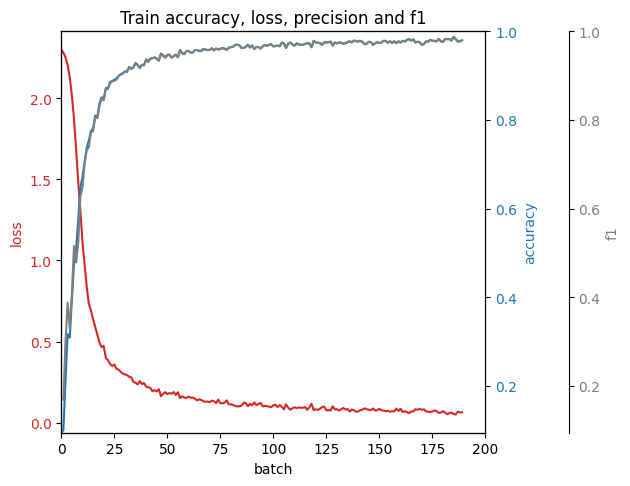

In [31]:
batch_size_model.plot()

In [32]:
# Hopothesis 2: increase learning rate with increased batch size results in faster learning and better accuracy

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

batch_size_learning_rate_model = Model('hip-2-model', net, trainloader, criterion, optimizer)
batch_size_learning_rate_model.train_and_test()

batch_size_learning_rate_model.show_table()

Training hip-2-model...
[1,     3] loss: 2.327, accuracy: 0.110
[1,     6] loss: 2.194, accuracy: 0.220
[1,     9] loss: 1.799, accuracy: 0.443
[1,    12] loss: 1.164, accuracy: 0.646
[1,    15] loss: 1.084, accuracy: 0.674
[1,    18] loss: 0.741, accuracy: 0.760
[1,    21] loss: 0.734, accuracy: 0.780
[1,    24] loss: 0.527, accuracy: 0.836
[1,    27] loss: 0.437, accuracy: 0.865
[1,    30] loss: 0.355, accuracy: 0.896
[1,    33] loss: 0.285, accuracy: 0.919
[1,    36] loss: 0.279, accuracy: 0.924
[1,    39] loss: 0.226, accuracy: 0.932
[1,    42] loss: 0.195, accuracy: 0.938
[1,    45] loss: 0.171, accuracy: 0.947
[1,    48] loss: 0.174, accuracy: 0.951
[1,    51] loss: 0.142, accuracy: 0.955
[1,    54] loss: 0.154, accuracy: 0.950
[1,    57] loss: 0.123, accuracy: 0.962
[2,     3] loss: 0.109, accuracy: 0.970
[2,     6] loss: 0.123, accuracy: 0.961
[2,     9] loss: 0.101, accuracy: 0.966
[2,    12] loss: 0.107, accuracy: 0.966
[2,    15] loss: 0.110, accuracy: 0.966
[2,    18] loss:

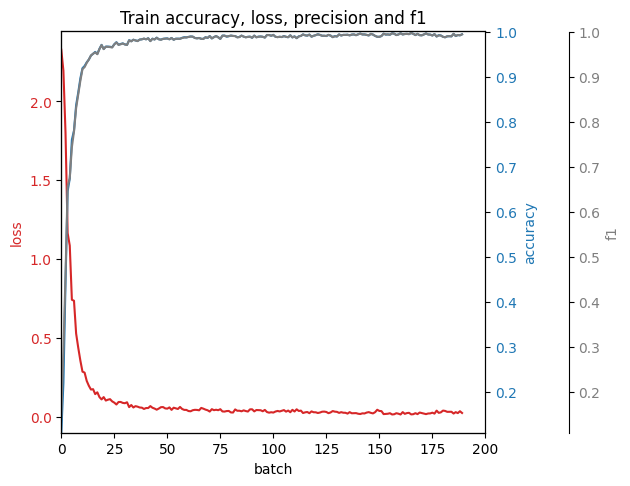

In [33]:
batch_size_learning_rate_model.plot()

In [34]:
# Hipothesis 3: Adam is better than SGD

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

sgd_model = Model('hip-3-model', net, trainloader, criterion, optimizer)
sgd_model.train_and_test()

sgd_model.show_table()

Training hip-3-model...
[1,    24] loss: 2.305, accuracy: 0.104
[1,    48] loss: 2.307, accuracy: 0.091
[1,    72] loss: 2.307, accuracy: 0.091
[1,    96] loss: 2.306, accuracy: 0.103
[1,   120] loss: 2.307, accuracy: 0.087
[1,   144] loss: 2.306, accuracy: 0.102
[1,   168] loss: 2.304, accuracy: 0.106
[1,   192] loss: 2.305, accuracy: 0.095
[1,   216] loss: 2.303, accuracy: 0.111
[1,   240] loss: 2.304, accuracy: 0.096
[1,   264] loss: 2.304, accuracy: 0.098
[1,   288] loss: 2.305, accuracy: 0.100
[1,   312] loss: 2.306, accuracy: 0.092
[1,   336] loss: 2.304, accuracy: 0.102
[1,   360] loss: 2.303, accuracy: 0.102
[1,   384] loss: 2.304, accuracy: 0.103
[1,   408] loss: 2.302, accuracy: 0.105
[1,   432] loss: 2.305, accuracy: 0.101
[1,   456] loss: 2.303, accuracy: 0.102
[1,   480] loss: 2.304, accuracy: 0.095
[2,    24] loss: 2.302, accuracy: 0.108
[2,    48] loss: 2.302, accuracy: 0.104
[2,    72] loss: 2.302, accuracy: 0.105
[2,    96] loss: 2.303, accuracy: 0.101
[2,   120] loss:

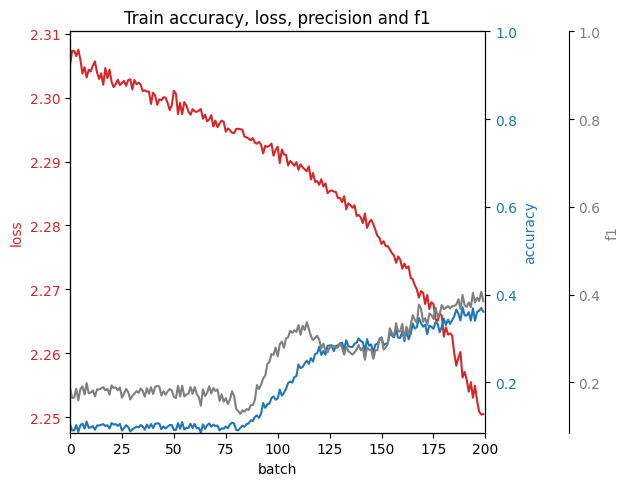

In [35]:
sgd_model.plot()

In [36]:
# Hipothesis 4: SGD with momentum is better than Adam

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

sgd_momentum_model = Model('hip-4-model', net, trainloader, criterion, optimizer)
sgd_momentum_model.train_and_test()

sgd_momentum_model.show_table()

Training hip-4-model...
[1,    24] loss: 2.305, accuracy: 0.105
[1,    48] loss: 2.304, accuracy: 0.102
[1,    72] loss: 2.299, accuracy: 0.101
[1,    96] loss: 2.297, accuracy: 0.103
[1,   120] loss: 2.294, accuracy: 0.099
[1,   144] loss: 2.293, accuracy: 0.099
[1,   168] loss: 2.288, accuracy: 0.131
[1,   192] loss: 2.285, accuracy: 0.226
[1,   216] loss: 2.281, accuracy: 0.233
[1,   240] loss: 2.279, accuracy: 0.221
[1,   264] loss: 2.270, accuracy: 0.281
[1,   288] loss: 2.265, accuracy: 0.276
[1,   312] loss: 2.260, accuracy: 0.301
[1,   336] loss: 2.251, accuracy: 0.330
[1,   360] loss: 2.239, accuracy: 0.394
[1,   384] loss: 2.223, accuracy: 0.379
[1,   408] loss: 2.203, accuracy: 0.383
[1,   432] loss: 2.169, accuracy: 0.346
[1,   456] loss: 2.142, accuracy: 0.401
[1,   480] loss: 2.096, accuracy: 0.430
[2,    24] loss: 1.993, accuracy: 0.490
[2,    48] loss: 1.871, accuracy: 0.544
[2,    72] loss: 1.681, accuracy: 0.591
[2,    96] loss: 1.451, accuracy: 0.642
[2,   120] loss:

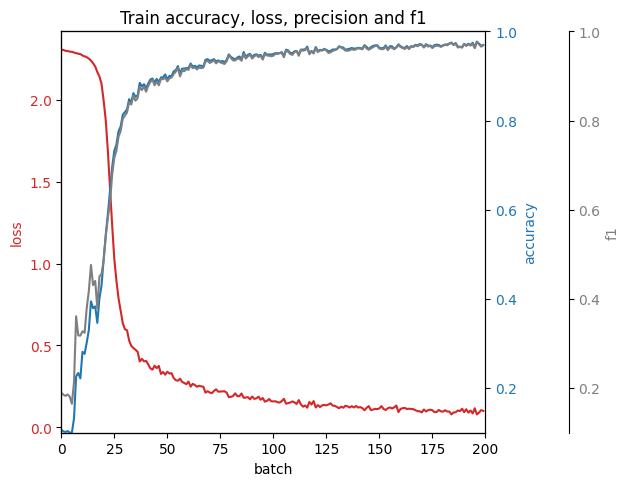

In [37]:
sgd_momentum_model.plot()

In [38]:
# Hipothesis 5: SGD with momentum and decay is better than SGD with momentum

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

sgd_momentum_decay_model = Model('hip-5-model', net, trainloader, criterion, optimizer)
sgd_momentum_decay_model.train_and_test()

sgd_momentum_decay_model.show_table()

Training hip-5-model...
[1,    24] loss: 2.305, accuracy: 0.106
[1,    48] loss: 2.302, accuracy: 0.101
[1,    72] loss: 2.300, accuracy: 0.110
[1,    96] loss: 2.299, accuracy: 0.129
[1,   120] loss: 2.297, accuracy: 0.151
[1,   144] loss: 2.298, accuracy: 0.156
[1,   168] loss: 2.296, accuracy: 0.161
[1,   192] loss: 2.292, accuracy: 0.182
[1,   216] loss: 2.292, accuracy: 0.185
[1,   240] loss: 2.289, accuracy: 0.189
[1,   264] loss: 2.287, accuracy: 0.202
[1,   288] loss: 2.286, accuracy: 0.208
[1,   312] loss: 2.283, accuracy: 0.208
[1,   336] loss: 2.278, accuracy: 0.212
[1,   360] loss: 2.275, accuracy: 0.194
[1,   384] loss: 2.271, accuracy: 0.178
[1,   408] loss: 2.266, accuracy: 0.178
[1,   432] loss: 2.264, accuracy: 0.187
[1,   456] loss: 2.257, accuracy: 0.245
[1,   480] loss: 2.249, accuracy: 0.318
[2,    24] loss: 2.233, accuracy: 0.381
[2,    48] loss: 2.221, accuracy: 0.402
[2,    72] loss: 2.198, accuracy: 0.453
[2,    96] loss: 2.172, accuracy: 0.508
[2,   120] loss:

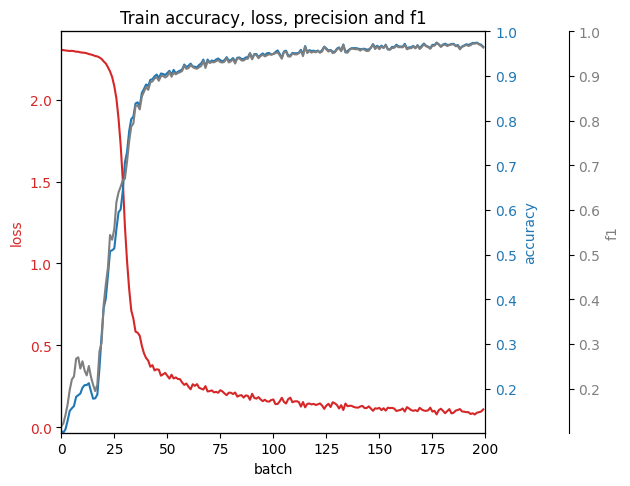

In [39]:
sgd_momentum_decay_model.plot()

In [40]:
# Hipothesis 6: different loss function

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nll_model = Model('hip-6-model', net, trainloader, criterion, optimizer)
nll_model.train_and_test()

nll_model.show_table()

Training hip-6-model...
[1,    24] loss: 2.187, accuracy: 0.300
[1,    48] loss: 1.260, accuracy: 0.634
[1,    72] loss: 0.638, accuracy: 0.798
[1,    96] loss: 0.502, accuracy: 0.844
[1,   120] loss: 0.428, accuracy: 0.863
[1,   144] loss: 0.329, accuracy: 0.902
[1,   168] loss: 0.340, accuracy: 0.897
[1,   192] loss: 0.351, accuracy: 0.897
[1,   216] loss: 0.282, accuracy: 0.915
[1,   240] loss: 0.222, accuracy: 0.935
[1,   264] loss: 0.225, accuracy: 0.931
[1,   288] loss: 0.206, accuracy: 0.938
[1,   312] loss: 0.206, accuracy: 0.938
[1,   336] loss: 0.162, accuracy: 0.950
[1,   360] loss: 0.159, accuracy: 0.958
[1,   384] loss: 0.156, accuracy: 0.954
[1,   408] loss: 0.145, accuracy: 0.955
[1,   432] loss: 0.144, accuracy: 0.958
[1,   456] loss: 0.122, accuracy: 0.961
[1,   480] loss: 0.125, accuracy: 0.961
[2,    24] loss: 0.095, accuracy: 0.971
[2,    48] loss: 0.102, accuracy: 0.968
[2,    72] loss: 0.133, accuracy: 0.957
[2,    96] loss: 0.108, accuracy: 0.963
[2,   120] loss:

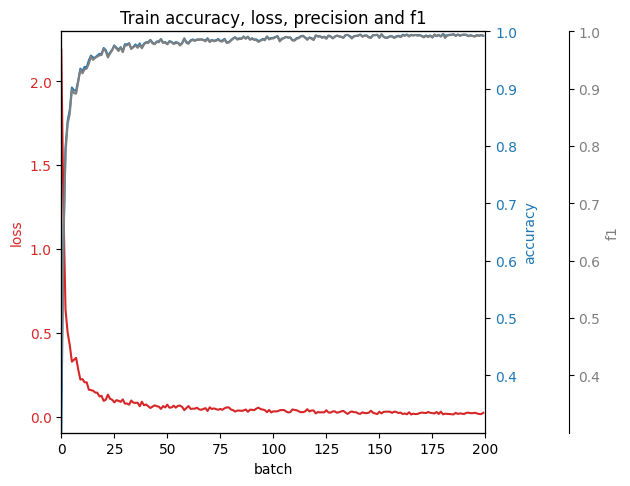

In [41]:
nll_model.plot()

In [42]:
# Hipothesis 7: rms props

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

rms_model = Model('hip-7-model', net, trainloader, criterion, optimizer)
rms_model.train_and_test()

rms_model.show_table()

Training hip-7-model...
[1,    24] loss: 1.297, accuracy: 0.573
[1,    48] loss: 0.384, accuracy: 0.881
[1,    72] loss: 0.312, accuracy: 0.907
[1,    96] loss: 0.213, accuracy: 0.934
[1,   120] loss: 0.209, accuracy: 0.931
[1,   144] loss: 0.202, accuracy: 0.944
[1,   168] loss: 0.174, accuracy: 0.949
[1,   192] loss: 0.136, accuracy: 0.959
[1,   216] loss: 0.170, accuracy: 0.949
[1,   240] loss: 0.137, accuracy: 0.957
[1,   264] loss: 0.114, accuracy: 0.964
[1,   288] loss: 0.135, accuracy: 0.959
[1,   312] loss: 0.107, accuracy: 0.968
[1,   336] loss: 0.110, accuracy: 0.968
[1,   360] loss: 0.124, accuracy: 0.965
[1,   384] loss: 0.092, accuracy: 0.968
[1,   408] loss: 0.094, accuracy: 0.968
[1,   432] loss: 0.107, accuracy: 0.965
[1,   456] loss: 0.099, accuracy: 0.969
[1,   480] loss: 0.075, accuracy: 0.976
[2,    24] loss: 0.078, accuracy: 0.975
[2,    48] loss: 0.092, accuracy: 0.970
[2,    72] loss: 0.088, accuracy: 0.972
[2,    96] loss: 0.081, accuracy: 0.974
[2,   120] loss:

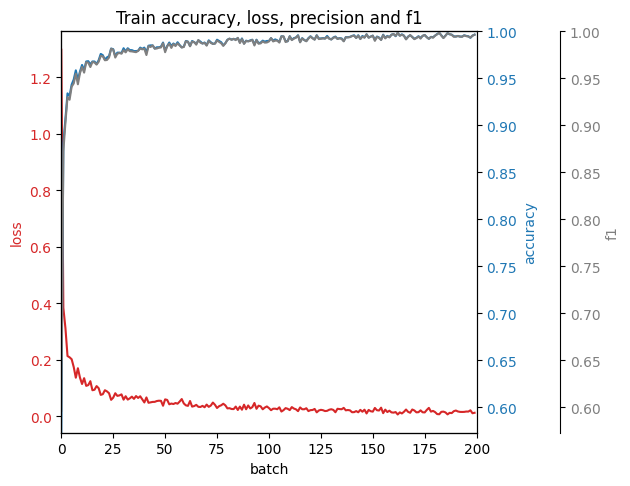

In [43]:
rms_model.plot()

In [44]:
# from sklearn.model_selection import ParameterGrid

# param_grid = {
#     'optimizer': ['adam', 'sgd', 'rmsprop'],
#     'loss_function': ['nnloss', 'binary_crossentropy'],
#     'batch_size': [64, 128, 1024],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'momentum': [0, 0.9],
# }

# def getLossFunction(loss_function):
#     return nn.NLLLoss() if loss_function == 'nnloss' else nn.CrossEntropyLoss()

# def getUniqueName(params):
#     return f'hyper-{params["optimizer"]}-{params["loss_function"]}-{params["batch_size"]}-{params["learning_rate"]}-{params["momentum"]}'


# print(f'Models to train: {len(ParameterGrid(param_grid))}')

# results = []
# i = 0
# for params in ParameterGrid(param_grid):
#     print(f'Training model {i+1}...')
#     if params['optimizer'] != 'sgd' and params['momentum'] == 0.9:
#         continue
    
#     if params['optimizer'] == 'sgd' :
#         net = Net().cuda()
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True)
#         criterion =  getLossFunction(params['loss_function'])
#         optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
#     else:
#         net = Net().cuda()
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True)
#         criterion =  getLossFunction(params['loss_function'])
#         optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'])
    
#     model = Model(getUniqueName(params), net, trainloader, criterion, optimizer)    
#     model.train_and_test()
    
#     results.append({
#         'params': params,
#         'name': model.name,
#         'train_time': model.train_time,
#         'test_time': model.test_time,
#         'test_loss': model.test_loss,
#         'test_accuracy': model.test_accuracy,
#         'test_f1': model.test_f1
#     })
    
#     i += 1
    
# print('Training finished')
# print(results)

In [45]:
# len(ParameterGrid(param_grid)) * (10) / 3060